<img src="./assets/airbnb_logo.png"
    style="width:300px; float: right; margin: 0 40px 40px 40px;"></img>
# Group Project AirBnB
**Useful links**

<a href="https://github.com/ShimantoRahman/aCRM-Group-Project-AirBnB"><img src="./assets/github_logo.png" style="width:120px; margin: 0 0 40px 40px;"></a>

> [Inside AirBnB: New York](http://insideairbnb.com/new-york-city/?fbclid=IwAR3lvDyNFboZqns1jNJ8v4OzqzG8sLFsqeSlRjqb_-tyvk4iM_XRSYdwmEQ)

> [Airbnb Rental Listings Dataset Mining](https://towardsdatascience.com/airbnb-rental-listings-dataset-mining-f972ed08ddec)

> [Airbnb and San Francisco: Descriptive Statistics and Academic Research](https://commissions.sfplanning.org/cpcpackets/2014-001033PCA.pdf?fbclid=IwAR14mQd4JQf0VB0BpWJX_ITYlg6aDZLEBivrM5L70xslYxjxUTsa1O5R2gQ)

## 1 Setup
### 1.1 Import and install modules

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from datetime import datetime
from datetime import timedelta  
import nltk
import os
import folium
import json
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer 
from collections import Counter
from wordcloud import WordCloud
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.anova import AnovaRM
import geopy.distance
sns.set()

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
!pip install -U textblob
!pip install WordCloud
!pip install folium
!pip install geopy

![green-divider](./assets/green_divider.png)

### 1.2 Read data

In [2]:
calendar_detail = pd.read_csv("./data/calendar_detail.csv")
listings_summary = pd.read_csv("./data/listings_summary.csv")
reviews_summary = pd.read_csv("./data/reviews_summary.csv")
neighbourhoods = pd.read_csv("./data/neighbourhoods.csv")

In [3]:
listings_detail = pd.read_csv("./data/listings_detail.csv", low_memory = False)

In [4]:
reviews_detail = pd.read_csv("./data/reviews_detail.csv")

In [5]:
text_analysis = pd.read_csv("./data/text_analysis.csv")
text_analysis["tokenized_filtered"] = text_analysis["tokenized_filtered"].apply(lambda x: x[2:-2].split('\', \''))

In [6]:
with open('./data/neighbourhoods.geojson') as json_file:
    geo_json_data = json.load(json_file)

In [ ]:
calendar_detail.head()

In [ ]:
listings_summary.head()

In [ ]:
reviews_summary.head()

In [ ]:
neighbourhoods.head()

In [ ]:
listings_detail.head()

In [ ]:
reviews_detail.head()

In [ ]:
text_analysis.head()

![green-divider](./assets/green_divider.png)

### 1.3 data preparation
#### 1.3.1 Detecting NaN values

In [ ]:
print("listings_summary\n")
print(listings_summary.isnull().sum())

In [ ]:
print("listings_detail\n")
print(listings_detail.isnull().sum())

In [ ]:
print("reviews_summary\n")
print(reviews_summary.isnull().sum())

In [ ]:
print("reviews_detail\n")
print(reviews_detail.isnull().sum())

In [ ]:
print("neighbourhoods\n")
print(neighbourhoods.isnull().sum())

In [ ]:
print("\ncalendar_detail\n")
print(calendar_detail.isnull().sum())

![green-divider](./assets/green_divider.png)

#### 1.3.2 Cleansing data

In [7]:
# removing listings where first and last review do not both match
ids = listings_detail[((listings_detail["first_review"].isnull()) & ~(listings_detail["last_review"].isnull()))].index
listings_summary.drop(ids , inplace=True)
listings_detail = listings_detail[~((listings_detail["first_review"].isnull()) & ~(listings_detail["last_review"].isnull()))]

# removing reviews without a comment
ids = reviews_detail[reviews_detail["comments"].isna()].index
reviews_summary.drop(ids , inplace=True)
reviews_detail = reviews_detail.dropna(subset=['comments'])

# removing listings without a superhost value
ids = listings_detail[listings_detail["host_is_superhost"].isna()].index
listings_summary.drop(ids , inplace=True)
listings_detail = listings_detail.dropna(subset=['host_is_superhost'])

In [8]:
# replacing NaN values for reviews_per_month to 0
# rows with NaN value for reviews_per_month do not have a first or last review, thus they have 0 reviews per month
column_imputations = {"reviews_per_month": 0}
listings_detail = listings_detail.fillna(value = column_imputations)
listings_summary = listings_summary.fillna(value = column_imputations)

![green-divider](./assets/green_divider.png)

#### 1.3.2 Correcting data types

In [9]:
# dates
def column_to_date(df, column):
    df[column] = pd.to_datetime(df[column], format="%Y-%m-%d")
    
# listings_summary
column_to_date(listings_summary, "last_review")

# reviews_summary
column_to_date(reviews_summary, "date")

# calendar_detail
column_to_date(calendar_detail, "date")

# listings_detail
column_to_date(listings_detail, "first_review")
column_to_date(listings_detail, "last_review")
column_to_date(listings_detail, "last_scraped")
column_to_date(listings_detail, "calendar_last_scraped")
column_to_date(listings_detail, "host_since")

# reviews_detail
column_to_date(reviews_detail, "date")

In [10]:
# change t/f columns to 1/0
label_encoder = LabelEncoder()

def column_to_bool(df, column):
    label_encoder.fit(df[column])
    new_column = column + "_num"
    df[new_column] = label_encoder.transform(df[column])

column_to_bool(listings_detail, "instant_bookable")
column_to_bool(listings_detail, "requires_license")
column_to_bool(listings_detail, "is_business_travel_ready")
column_to_bool(listings_detail, "require_guest_profile_picture")
column_to_bool(listings_detail, "require_guest_phone_verification")
column_to_bool(listings_detail, "instant_bookable")
column_to_bool(listings_detail, "host_is_superhost")
column_to_bool(listings_detail, "has_availability")

In [11]:
# change categorical columns to numerical labels
def column_to_numeric_labels(df, column):
    label_encoder = LabelEncoder()
    label_encoder.fit(df[column])
    df[column + "_num"] = label_encoder.transform(df[column])

column_to_numeric_labels(listings_summary, "neighbourhood_group")
column_to_numeric_labels(listings_summary, "neighbourhood")
column_to_numeric_labels(listings_summary, "room_type")

In [12]:
# changing price from $00.0 [String] to 00.0 float 

calendar_detail["price"] = calendar_detail["price"].str.replace("$", "")
calendar_detail["price"] = calendar_detail["price"].str.replace(",", "")
calendar_detail["price"] = pd.to_numeric(calendar_detail["price"])

listings_detail["price"] = listings_detail["price"].str.replace("$", "")
listings_detail["price"] = listings_detail["price"].str.replace(",", "")
listings_detail["price"] = pd.to_numeric(listings_detail["price"])

![green-divider](./assets/green_divider.png)

## 2 Analysis
### 2.1 Calculate the average listing price per neighbourhood

In [13]:
print(listings_summary.groupby("neighbourhood").mean()["price"])

neighbourhood
Allerton                       71.086957
Arden Heights                  37.750000
Arrochar                      140.533333
Arverne                       128.432432
Astoria                       116.277844
Bath Beach                     90.454545
Battery Park City             251.559322
Bay Ridge                      90.549550
Bay Terrace                   112.857143
Bay Terrace, Staten Island    112.500000
Baychester                     63.500000
Bayside                       110.333333
Bayswater                      72.400000
Bedford-Stuyvesant            101.495259
Belle Harbor                  115.000000
Bellerose                     184.375000
Belmont                        62.875000
Bensonhurst                    82.255319
Bergen Beach                   97.375000
Boerum Hill                   169.416667
Borough Park                  125.214286
Briarwood                     124.312500
Brighton Beach                122.448980
Bronxdale                      60.473684
Br

### 2.2 Plot how the average price evolves through the year across New York.

#### Mean

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


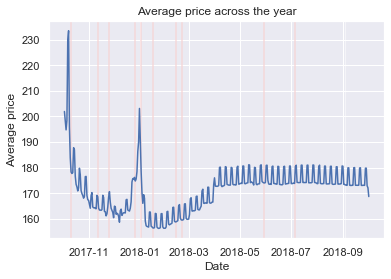

In [14]:
avg_price_day = calendar_detail[["date", "price"]].groupby("date").mean().reset_index()


holiday_dates = {"holiday":['2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25', '2018-01-01', '2018-01-15', '2018-02-12', 
                 '2018-02-19', '2018-05-28', '2018-07-04', '2018-09-03']}

holiday_dates_df = pd.DataFrame(holiday_dates)

def column_to_date(df, column):
    df[column] = pd.to_datetime(df[column], format="%Y-%m-%d")
column_to_date(holiday_dates_df, "holiday")


for index, day in holiday_dates_df.iterrows():
    tomorrow = day + timedelta(days = 1)
    plt.axvspan(day, tomorrow, facecolor='#d62728', alpha=0.5)

sns.lineplot(x = "date", y = "price", data = avg_price_day)
plt.xlabel("Date")
plt.ylabel("Average price")
plt.title("Average price across the year")
plt.show()

#### Median

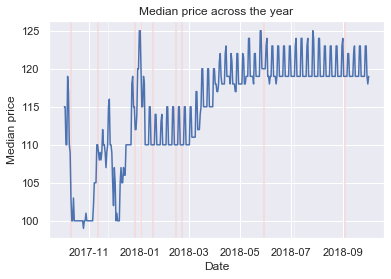

In [15]:
median_price_day = calendar_detail[["date", "price"]].groupby("date").median().reset_index()


holiday_dates = {"holiday":['2017-10-09', '2017-11-10', '2017-11-23', '2017-12-25', '2018-01-01', '2018-01-15', '2018-02-12', 
                 '2018-02-19', '2018-05-28', '2018-07-04', '2018-09-03']}

holiday_dates_df = pd.DataFrame(holiday_dates)

def column_to_date(df, column):
    df[column] = pd.to_datetime(df[column], format="%Y-%m-%d")
column_to_date(holiday_dates_df, "holiday")


for index, day in holiday_dates_df.iterrows():
    tomorrow = day + timedelta(days = 1)
    plt.axvspan(day, tomorrow, facecolor='#d62728', alpha=0.5)

sns.lineplot(x = "date", y = "price", data = median_price_day)
plt.xlabel("Date")
plt.ylabel("Median price")
plt.title("Median price across the year")
plt.show()

### 2.3	Identify which neighborhood has the largest price fluctuations across the year. Plot the fluctuations for this neighborhood.

In [16]:
# joining listings_summary with calendar_detail
cal_listing = pd.merge(calendar_detail, listings_summary[["id", "neighbourhood"]], how="inner", left_on="listing_id", right_on = "id")

In [17]:
# calculating variance per neighbourhood and requesting top one
price_by_neighbourhood = cal_listing[["neighbourhood", "price"]].groupby("neighbourhood").var().reset_index()
nb_with_largest_var = price_by_neighbourhood.sort_values("price", ascending = False).iloc[0]["neighbourhood"]

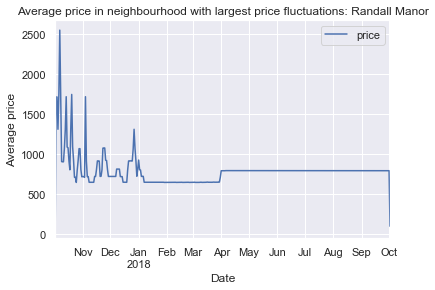

In [18]:
# plotting the prices of the neighbourhood with the largest price fluctuations
cal_listing[["date", "price", "neighbourhood"]][cal_listing["neighbourhood"] == nb_with_largest_var].groupby("date").mean().plot()
plt.xlabel("Date")
plt.ylabel("Average price")
plt.title("Average price in neighbourhood with largest price fluctuations: " + nb_with_largest_var)
plt.show()

### 2.4 In marketing, there is a phenomenon known as ‘the long tail’ (Hint: look it up). This also translates to the number of reviews. Plot this on an intuitive graph.

#### Definition
**The long tail** is a business strategy that allows companies to realize significant profits 
by selling low volumes of hard-to-find items to many customers, 
instead of only selling large volumes of a reduced number of popular items.

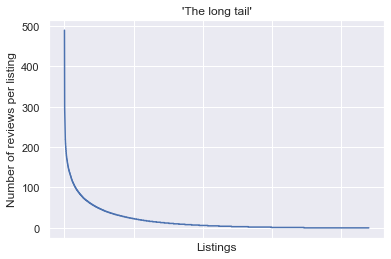

In [19]:
# prepare dataframe in correct ordering
listing_review_sorted = listings_summary[["id", "number_of_reviews"]].sort_values("number_of_reviews", ascending = False)
listing_review_sorted["id_factor"] = listing_review_sorted["id"].astype('category')
listing_review_sorted = listing_review_sorted.sort_values("number_of_reviews", ascending = False).reset_index()
del listing_review_sorted["index"]
listing_review_sorted = listing_review_sorted.sort_values("number_of_reviews", ascending = False).reset_index()
listing_review_sorted

# plot
sns.lineplot(x = "index", y = "number_of_reviews", data = listing_review_sorted)
plt.title("'The long tail'")
plt.xlabel("Listings")
plt.ylabel("Number of reviews per listing")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

### 2.5	Run a regression to explain the price per listing. (Hint: location, reviews, etc. may all explain this).

#### Calculating the distance between the listings and important landmarks in new york

In [20]:
def test_distance_monoment(row):
    coord_latitude_listing = row["latitude"] 
    coord_longitude_listing = row["longitude"]
    coord_listing = (coord_latitude_listing, coord_longitude_listing)
    
    coordinateslandmarks = {"Central Park":{"latitude":40.785091,"longitude":-73.968285},
                        "Times Square & Broadway":{"latitude":40.758896,"longitude":-73.985130},
                       "Grand Central Terminal":{"latitude":40.752726,"longitude":-73.977229},
                       "Rockefeller Center":{"latitude":40.758740,"longitude":-73.978674},
                       "High Line":{"latitude":40.74773,"longitude":-74.004929},
                       "Coney Island":{"latitude":40.57788,"longitude":-73.99403},
                       "One World Trade Center":{"latitude":40.712742,"longitude":-74.013382},
                       "Metropolitan Museum of Art":{"latitude":40.778965,"longitude":-73.962311},
                       "Statue of Liberty":{"latitude":40.689247,"longitude":-74.044502},
                       "Empire State Building":{"latitude":40.748817,"longitude":-73.985428}}
    
    count = 0
    for key,value in coordinateslandmarks.items():
        coord_landmark_latitude = value['latitude'] 
        coord_landmark_longitude = value['longitude']
        coord_landmark = (coord_landmark_latitude, coord_landmark_longitude)
    
        distance = geopy.distance.distance(coord_landmark, coord_listing).miles
        if distance < 4.0:
            count += 1
            
    return count

In [21]:
listings_detail["count_close_to_landmark"] = listings_detail.apply(lambda row: test_distance_monoment(row), axis = 1)

#### Regression models

In [22]:
# dependent variable
dep = "price"

# independent variables
indeps = "C(neighbourhood_group_cleansed) + C(room_type) + reviews_per_month + C(host_is_superhost) + calculated_host_listings_count + count_close_to_landmark"

# Fit regression model 
model = smf.ols(dep +"~"+ indeps, data=listings_detail).fit()

# inspect the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.112
Model:                            OLS   Adj. R-squared:                  0.112
Method:                 Least Squares   F-statistic:                     554.5
Date:                Sat, 26 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:53:30   Log-Likelihood:            -2.9538e+05
No. Observations:               44056   AIC:                         5.908e+05
Df Residuals:                   44045   BIC:                         5.909e+05
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                                       coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------

In [23]:
# alternative model
df = listings_detail
df.dropna(subset=['bedrooms', 'bathrooms'])

# dependent variable
dep = "price"

# independent variables
indeps = "C(neighbourhood) + bathrooms + bedrooms + I(bedrooms**2)"

# Fit regression model 
model = smf.ols(dep +"~"+ indeps, data=df).fit()

# inspect the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.190
Model:                            OLS   Adj. R-squared:                  0.186
Method:                 Least Squares   F-statistic:                     50.20
Date:                Sat, 26 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:53:31   Log-Likelihood:            -2.9182e+05
No. Observations:               43834   AIC:                         5.841e+05
Df Residuals:                   43629   BIC:                         5.858e+05
Df Model:                         204                                         
Covariance Type:            nonrobust                                         
                                                        coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------

### 2.6 Find additional data sources to explain the average listing price per neighbourhood. (Hint : think demographics)

In [27]:
# read csv file demographics
fields = ["county", "population_estimates", "white_alone", "housing_units", "owner_occupied_housing_unit_rate", "median_gross_rent"]
demographics = pd.read_csv("./data/demographics_manual_table.csv",sep = ";", header = 0, names = fields)
demographics.head()

county  population_estimates  white_alone  housing_units  \
0  Staten Island                476179         60.3         181199   
1          Bronx               1432132          9.1         532487   
2         Queens               2278906         25.0         865878   
3       Brooklyn               2582830         36.4        1053767   
4      Manhattan               1628701         47.0         886249   

   owner_occupied_housing_unit_rate  median_gross_rent  
0                              69.5               1229  
1                              19.7               1133  
2                              44.5               1456  
3                              30.0               1314  
4                              24.1               1615

In [28]:
# join demographics to listings_detail
listings_detail_demographics = listings_detail.merge(demographics, how = "left", left_on = "neighbourhood_group_cleansed", right_on = "county")

np.corrcoef(listings_detail_demographics["median_gross_rent"], listings_detail_demographics["owner_occupied_housing_unit_rate"])
# listings_detail_demographics[["county", "population_estimates", "white_alone", "housing_units", "owner_occupied_housing_unit_rate", "median_gross_rent"]].var()

array([[ 1.        , -0.41160566],
       [-0.41160566,  1.        ]])

We select median_gross_rent as first demographic variable because it has the highest correlation (0.151) with price 2nd variable is white_alone, which is the percentage of white people (not hispanic or latino)

In [29]:
# dependent variable
dep = "price"

# independent variables
indeps = "C(room_type) + reviews_per_month + C(host_is_superhost) + calculated_host_listings_count + count_close_to_landmark + median_gross_rent + white_alone"

# Fit regression model 
model = smf.ols(dep +"~"+ indeps, data=listings_detail_demographics).fit()

# inspect the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.111
Model:                            OLS   Adj. R-squared:                  0.111
Method:                 Least Squares   F-statistic:                     689.9
Date:                Sat, 26 Oct 2019   Prob (F-statistic):               0.00
Time:                        16:55:28   Log-Likelihood:            -2.9539e+05
No. Observations:               44056   AIC:                         5.908e+05
Df Residuals:                   44047   BIC:                         5.909e+05
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                     coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------------
Intercept   

### 2.7 Plot how the average prices differ across New York using a color-coded heat map of New York neighborhoods.

In [30]:
# mean prices per neighbourhood
price_data = listings_summary[["neighbourhood", "price"]].groupby("neighbourhood").mean().reset_index()

In [107]:
# plot map
m = folium.Map([40.6976637, -74.1197643], tiles='cartodbpositron', zoom_start=10)

m.choropleth(
    geo_data= geo_json_data,
    name='choropleth',
    data= price_data,
    columns=['neighbourhood', 'price'],
    key_on='properties.neighbourhood',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Average price'
)

# m.save("./assets/graphs/prices.html")

m

C:\ProgramData\Anaconda3\lib\site-packages\folium\folium.py:415: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


### 2.8 The latitude of Statue of Liberty National Monument, New York, USA is 40.68927, and the longitude is -74.044502. This monument is one of the most popular tourist places in New York. Statistically test wether a distance smaller than 2 miles to the monument increases average listing price.

#### Calculating distance between listing and Statue of Liberty

In [32]:
def test_distance(row):
    coords_statue_liberty = (40.68927, -74.044502)
    coord_latitude_listing = row["latitude"] 
    coord_longitude_listing = row["longitude"]
    coord_listing = (coord_latitude_listing, coord_longitude_listing)
    
    distance = geopy.distance.distance(coords_statue_liberty, coord_listing).miles
    if distance < 2.0:
        in_radius = True
    else:
        in_radius = False
    return in_radius

In [33]:
listings_summary["in_radius"] = listings_summary.apply(lambda row: test_distance(row), axis = 1)

#### Regression

In [34]:
# dependent variable
dep = "price"

# independent variables
indeps = "in_radius"

# Fit regression model 
model = smf.ols(dep +"~"+ indeps, data=listings_summary).fit()

# inspect the model
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.436
Date:                Sat, 26 Oct 2019   Prob (F-statistic):             0.0638
Time:                        16:55:53   Log-Likelihood:            -2.9799e+05
No. Observations:               44056   AIC:                         5.960e+05
Df Residuals:                   44054   BIC:                         5.960e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept           147.6365      0.99

### 2.9	Create a timeline and plot for each month the highest, Q1, the median, Q3 and lowest price on one graph. Do this for each neighborhood group as well as for the entire city. Determine which neighborhood group stands out the most and create a comparative graph of this neighborhood with all other groups.

In [35]:
#define def to convert Timestamp to name of month
def timestamp_to_month(date):
    name = datetime.strftime(date, '%b')
    return name

In [36]:
def nb_boxplot(neighbourhoodgroup):
    nbg = listings_summary["id"][listings_summary["neighbourhood_group"]==neighbourhoodgroup]
    nbg = pd.merge(nbg, calendar_detail, left_on="id", right_on="listing_id", how="inner").drop(columns=["id"])

    #drop listings  = NaN
    nbg = nbg.dropna()
    nbg = nbg.sort_values('date')

    #converting dates to months (names)
    nbg["date"] = nbg["date"].apply(timestamp_to_month)

    plt.figure(figsize=(15, 8))

    ax = sns.boxplot(x = "date", y = "price", data = nbg)
    ax.set_ylim([0, 550])
    plt.xlabel("Month")
    plt.show()

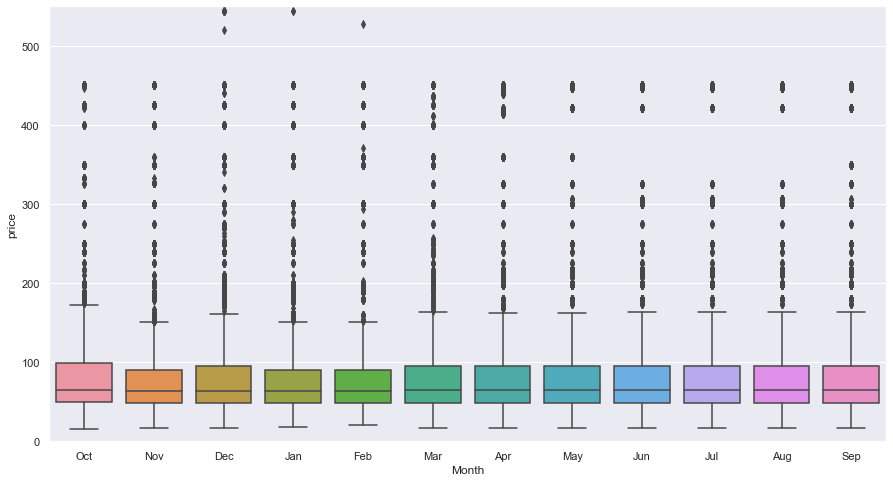

In [37]:
nb_boxplot("Bronx")

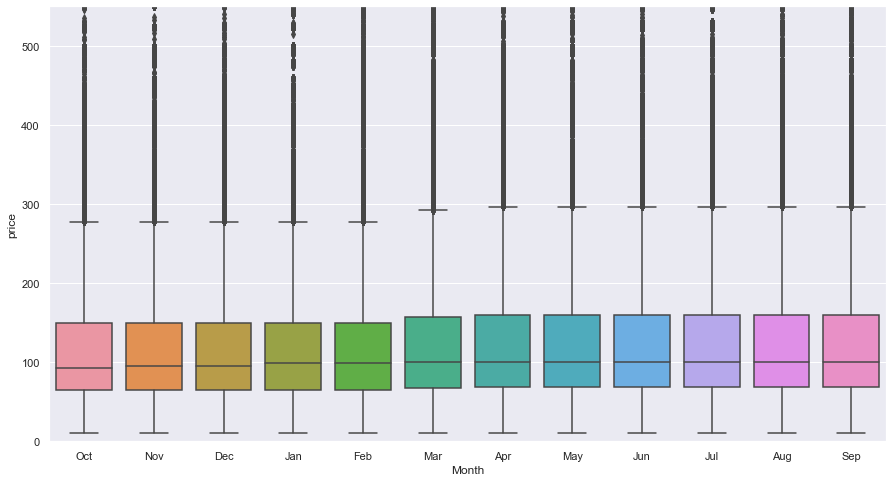

In [38]:
nb_boxplot("Brooklyn")

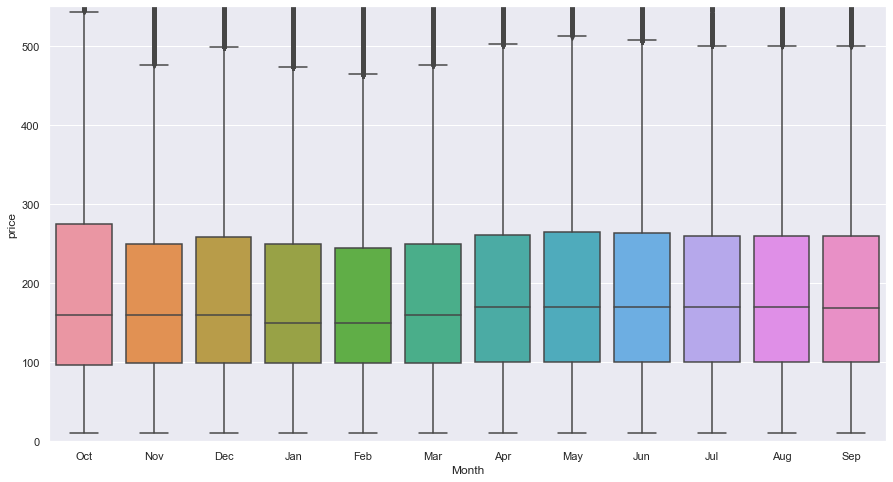

In [39]:
nb_boxplot("Manhattan")

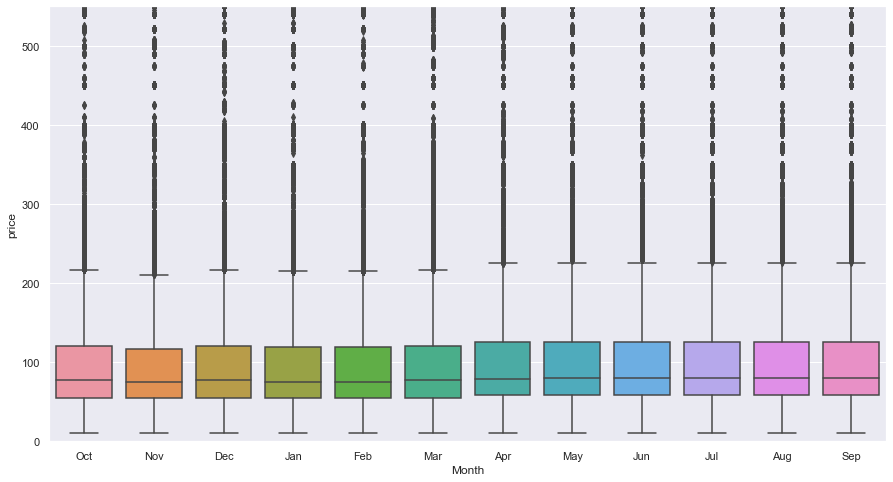

In [40]:
nb_boxplot("Queens")

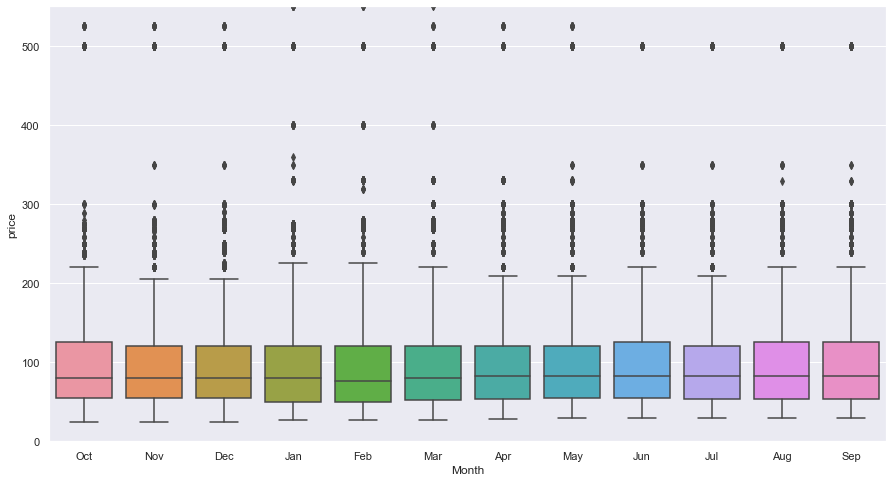

In [41]:
nb_boxplot("Staten Island")

### 2.10 Plot the number of rooms per host in function of the number of reviews per host. 
#### computing reviews per listing

In [42]:
temp = listings_summary[["host_id", "calculated_host_listings_count"]]
agg_dict = {"number_of_reviews":sum}
id_reviews = listings_summary.groupby("host_id").agg(agg_dict).reset_index().rename(columns={"number_of_reviews": "total_number_of_reviews"})
temp = temp.drop_duplicates()
host_count_reviews = pd.merge(temp, id_reviews, how = "right", on = "host_id")

#### plot with jitter to x-axis

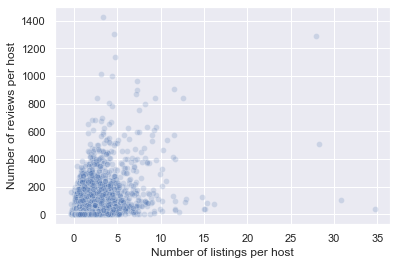

In [43]:
# define function jitter based on stdev
def rand_jitter(arr):
    stdev = .01*(max(arr)-min(arr))
    return arr + np.random.randn(len(arr)) * stdev

# convert to numpy arrays
x = np.array(host_count_reviews["calculated_host_listings_count"])
y = np.array(host_count_reviews["total_number_of_reviews"])

# plot seaborn
sns.scatterplot(x = rand_jitter(x), y = y, alpha = 0.2)
plt.xlabel("Number of listings per host")
plt.ylabel("Number of reviews per host")
plt.show()

### 2.11 Are there a lot of hosts having multiple locations? Do most people just rent their own place? Is there a ‘host long tail’? Make a comprehensive plot.

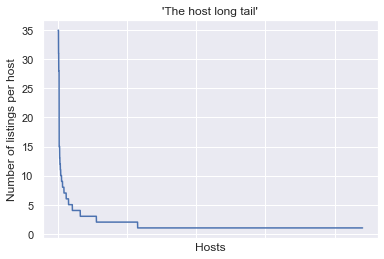

In [44]:
# prepare dataframe in correct ordering
host_listing_sorted = listings_summary[["host_id", "calculated_host_listings_count"]].sort_values("calculated_host_listings_count", ascending = False)
host_listing_sorted = host_listing_sorted.sort_values("calculated_host_listings_count", ascending = False).reset_index()
del host_listing_sorted["index"]
host_listing_sorted = host_listing_sorted.sort_values("calculated_host_listings_count", ascending = False).reset_index()
host_listing_sorted

# plot
sns.lineplot(x = "index", y = "calculated_host_listings_count", data = host_listing_sorted)
plt.title("'The host long tail'")
plt.xlabel("Hosts")
plt.ylabel("Number of listings per host")
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
plt.show()

### 2.12 Do hosts with multiple locations stay within the same neighbourhood? (hint: use subset)

In [45]:
# calculating:
# number of hosts with multiple locations
# number of hosts with multiple locations in different neighbourhoods
# number of hosts with multiple locations in the same neighbourhood

mult_loc = listings_summary[["id", "host_id"]].groupby("host_id").apply(lambda x: 1 if len(x) > 1 else 0).sum()
mult_loc_diff_nb = listings_summary[["host_id", "neighbourhood"]].groupby("host_id").apply(lambda x: 1 if len(x["neighbourhood"].unique()) > 1 else 0).sum()
mult_loc_same_nb = mult_loc - mult_loc_diff_nb

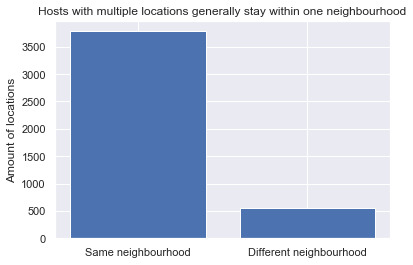

In [46]:
# barplot
plt.bar(["Same neighbourhood", "Different neighbourhood"], [mult_loc_same_nb, mult_loc_diff_nb])
plt.title("Hosts with multiple locations generally stay within one neighbourhood")
plt.ylabel("Amount of locations")
plt.show()

### 2.13 What are the 5 most used words in reviews that are no stop words? (e.g. the, or, etc. Python can filter these automatically using packages such as NLTK).
#### NLTK data prep
> read text_analysis.csv instead, because some steps like tokenizing take very long

In [ ]:
reviews_detail["comments_length"]= reviews_detail["comments"].str.len()

In [ ]:
reviews_detail["comments_length"].describe()

In [ ]:
reviews_detail[reviews_detail["comments_length"]==1].head(10)

In [ ]:
# removing comments with just a space or a dot
text_analysis = reviews_detail[reviews_detail['comments']!=' ']
text_analysis = text_analysis[text_analysis['comments']!='.']

In [ ]:
# turning every comment to lower case
text_analysis["comments"] = text_analysis["comments"].str.lower()

In [ ]:
# counting how many times a review has been posted
review_counts = text_analysis.comments.value_counts()

In [ ]:
# request top 20 most common comments
# A lot of the reviews are automated posts
review_counts[0:20]

In [ ]:
# removing automated posts
text_analysis = text_analysis[text_analysis["comments"].str.find("this is an automated posting.") == -1]

In [ ]:
# recounting how many times a review has been posted
review_counts = text_analysis.comments.value_counts()

In [ ]:
# request top 20 most common comments
review_counts[0:20]

In [ ]:
# splits comments into tokens (takes a while)
text_analysis['tokenized_comments'] = text_analysis.apply(lambda row: nltk.word_tokenize(row['comments']), axis=1)

In [ ]:
# lemmatize tokens  
lemmatizer = WordNetLemmatizer() 

text_analysis['lemmatized_comments'] = text_analysis.apply(lambda row: [lemmatizer.lemmatize(w) for w in row["tokenized_comments"]], axis=1)

In [ ]:
# counting the words in every comment
text_analysis['word_count'] = [ len(words) for words in text_analysis['tokenized_comments'] ]

In [ ]:
# removing stop words and punctuation from the tokens
filter_tokens = set(stopwords.words('english'))
filter_tokens.update({".", "?", "!", ",", ";", ":", "(", ")", "{", "}", "[", "]", "-", "&", "..."})

# other not useful words
filter_tokens.update({"'s", "would", "de", "n't", "us", "wa", "u", "la", "et", "e", "à", "le", "ha", "très", "est", "en", "un"})

text_analysis['tokenized_filtered'] = text_analysis['lemmatized_comments'].apply(lambda x: [item for item in x if item not in filter_tokens])

In [ ]:
text_analysis["comments_length"]= text_analysis["comments"].str.len()

In [ ]:
# calculating sentiment for every review
from textblob import TextBlob
reviews_detail["sentiment"] = reviews_detail["comments"].apply(lambda x: TextBlob(x).sentiment.polarity)
text_analysis = pd.merge(text_analysis, reviews_detail[["id", "sentiment"]], how = "inner", on = "id")

In [ ]:
# write text_analysis to csv
text_analysis[["id", "comments_length", "tokenized_filtered", "word_count", "sentiment"]].to_csv("./data/text_analysis.csv", index = False)

#### NLTK analysis

In [47]:
# stores 100 most common words
flat_list = [item for sublist in text_analysis["tokenized_filtered"] for item in sublist]
most_common_words = Counter(flat_list).most_common(100)

In [48]:
# requests 5 most common words
most_common_words

[('great', 472562),
 ('place', 426672),
 ('apartment', 390171),
 ('stay', 369993),
 ('host', 249279),
 ('clean', 248112),
 ('location', 230393),
 ('nice', 206530),
 ('room', 197395),
 ('time', 172543),
 ('subway', 170117),
 ('really', 156186),
 ('comfortable', 153643),
 ('recommend', 143586),
 ('good', 142951),
 ('everything', 142306),
 ('close', 130353),
 ('easy', 125683),
 ('perfect', 119098),
 ('also', 106802),
 ('well', 106370),
 ('definitely', 104527),
 ('restaurant', 103037),
 ('manhattan', 102047),
 ('neighborhood', 101177),
 ('helpful', 97230),
 ('new', 96936),
 ('home', 94557),
 ('bed', 93993),
 ('get', 92221),
 ('nyc', 91525),
 ('area', 83502),
 ('friendly', 82110),
 ('like', 80570),
 ('york', 79121),
 ('walk', 78994),
 ('day', 78857),
 ('night', 78239),
 ('super', 78140),
 ('made', 78131),
 ('experience', 77273),
 ('one', 75138),
 ('quiet', 74903),
 ('city', 74286),
 ('lot', 74015),
 ('staying', 73341),
 ('minute', 72828),
 ('even', 72403),
 ('need', 72330),
 ('could', 71866

**Word Cloud**

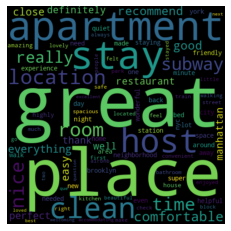

In [49]:
# turning most common words list into a string to use for the wordcloud
# refactor by using frequency table later
amount = np.array([x[1] for x in most_common_words])
normalized_amount = np.round(((amount / amount[0]) * 100))
text = ""
for i in range(0, len(most_common_words)):
    for j in range(0, int(normalized_amount[i])):
        text += " " + most_common_words[i][0]
        
wordcloud = WordCloud(collocations=False, width=480, height=480, margin=0).generate(text[1:])

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.margins(x=0, y=0)
plt.show()

#### Sentiment analysis

In [ ]:
reviews_detail = pd.merge(reviews_detail, text_analysis[["id", "sentiment"]], how = "left", on = "id")

In [ ]:
# calculate the average sentiment per listing
# adds average sentiments to the listings_summary
sentiments = reviews_detail[["listing_id", "sentiment"]].groupby("listing_id").mean().reset_index()
listings_summary = pd.merge(listings_summary, sentiments, how = "left", left_on = "id", right_on = "listing_id")
listings_summary.head()

### 2.14 Do these most frequent words differ across neighborhoods? What are the ‘most different’ areas? What distinguishes them? Interpret.

In [50]:
df = pd.merge(text_analysis, reviews_detail[["id", "listing_id"]], how = "inner", on = "id")
df = pd.merge(df, listings_summary[["id", "neighbourhood_group", "neighbourhood"]], how = "inner", left_on = "listing_id", right_on = "id")

In [51]:
pop_words_nbg = {}
for nb in listings_summary["neighbourhood_group"].unique():
    flat_list = [item for sublist in df[df["neighbourhood_group"] == nb]["tokenized_filtered"] for item in sublist]
    pop_words_nbg[nb] = Counter(flat_list).most_common(20)

In [52]:
pop_words_nb = {}
for nb in listings_summary["neighbourhood"].unique():
    flat_list = [item for sublist in df[df["neighbourhood"] == nb]["tokenized_filtered"] for item in sublist]
    pop_words_nb[nb] = Counter(flat_list).most_common(10)

In [54]:
pop_words_nb

{'Ditmars Steinway': [('place', 3415),
  ('great', 3133),
  ('stay', 2717),
  ('apartment', 2160),
  ('clean', 2029),
  ('room', 1895),
  ('host', 1852),
  ('nice', 1780),
  ('subway', 1481),
  ('location', 1300)],
 'City Island': [('great', 241),
  ('island', 211),
  ('city', 209),
  ('place', 204),
  ('stay', 187),
  ('host', 153),
  ('apartment', 117),
  ('phoebe', 110),
  ('home', 108),
  ('clean', 105)],
 'Allerton': [('place', 571),
  ('stay', 484),
  ('great', 449),
  ('room', 407),
  ('nice', 332),
  ('clean', 318),
  ('pat', 316),
  ('host', 308),
  ('apartment', 281),
  ('time', 259)],
 'Gerritsen Beach': [],
 'Soundview': [('place', 81),
  ('stay', 70),
  ('great', 60),
  ('ronald', 58),
  ('room', 51),
  ('host', 40),
  ('clean', 35),
  ('nice', 34),
  ('alicia', 29),
  ('apartment', 29)],
 'Ozone Park': [('place', 488),
  ('stay', 449),
  ('great', 380),
  ('clean', 349),
  ('host', 344),
  ('israel', 295),
  ('room', 279),
  ('nice', 264),
  ('house', 231),
  ('time', 230

In [56]:
pop_words_nbg

{'Queens': [('place', 47855),
  ('great', 40435),
  ('stay', 38359),
  ('clean', 30586),
  ('room', 27882),
  ('host', 26978),
  ('nice', 25274),
  ('apartment', 22604),
  ('subway', 17185),
  ('time', 16442),
  ('good', 16060),
  ('comfortable', 15775),
  ('location', 15680),
  ('really', 14822),
  ('recommend', 14503),
  ('close', 14381),
  ('everything', 13737),
  ('manhattan', 13056),
  ('house', 11829),
  ('easy', 11555)],
 'Bronx': [('place', 7471),
  ('stay', 6466),
  ('great', 6039),
  ('host', 4746),
  ('room', 4452),
  ('clean', 4346),
  ('nice', 3953),
  ('apartment', 3341),
  ('time', 2783),
  ('subway', 2707),
  ('comfortable', 2669),
  ('good', 2533),
  ('really', 2447),
  ('recommend', 2387),
  ('home', 2210),
  ('everything', 2168),
  ('close', 1911),
  ('definitely', 1892),
  ('house', 1813),
  ('neighborhood', 1708)],
 'Brooklyn': [('great', 191383),
  ('place', 177936),
  ('stay', 154914),
  ('apartment', 145246),
  ('host', 99711),
  ('clean', 99321),
  ('nice', 870

In [61]:
def draw_word_map(word):
    
    df["word_count_temp"]= df["tokenized_filtered"].apply(lambda row: row.count(word))
    word_data = df[["neighbourhood", "word_count_temp"]].groupby("neighbourhood").sum().reset_index()
    
    # plot map
    m = folium.Map([40.6976637, -74.1197643], tiles='cartodbpositron', zoom_start=10)

    m.choropleth(
        geo_data= geo_json_data,
        name='choropleth',
        data= word_data,
        columns=['neighbourhood', 'word_count_temp'],
        key_on='properties.neighbourhood',
        fill_color='Blues',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name='Word frequency',
    )
    display(m)

In [62]:
draw_word_map("ferry")

In [63]:
draw_word_map("subway")

In [64]:
draw_word_map("airport")

In [65]:
draw_word_map("restaurant")

### 2.15 Plot the amount of reviews across time. 
#### Daily

In [66]:
# number of reviews per date
rev_per_date = reviews_summary.groupby("date").size().reset_index(name="counts")

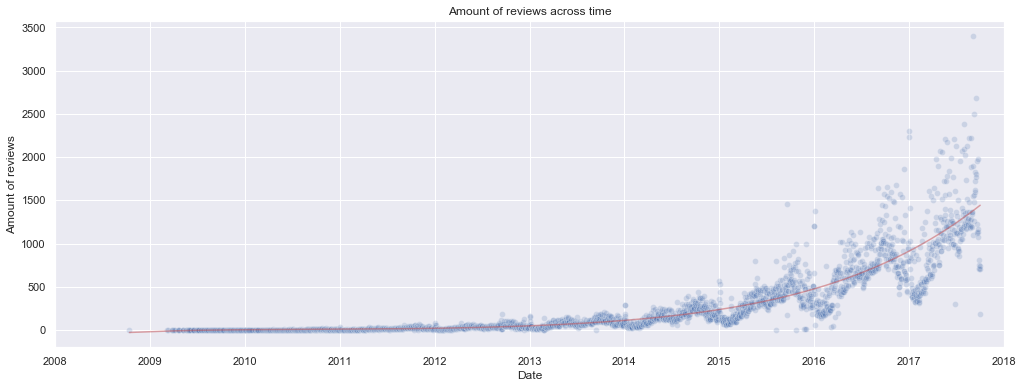

In [67]:
# plot the data itself
import datetime
x = pd.to_numeric(rev_per_date["date"])
y = rev_per_date["counts"]


plt.figure(figsize=(17, 6))
sns.scatterplot(rev_per_date["date"], y, alpha = 0.2)
plt.title("Amount of reviews across time")
plt.xlabel("Date")
plt.ylabel("Amount of reviews")
plt.xlim((datetime.datetime(2008, 1, 1),datetime.datetime(2018, 1, 1)))


# calc the trendline
z = np.polyfit(x, y, 5)
p = np.poly1d(z)
plt.plot(rev_per_date["date"],p(x),"r-", alpha = 0.5)

#### Yearly

In [68]:
# aggregating results by year
rev_per_date['year'] = [t.year for t in rev_per_date.date]
rev_per_year = rev_per_date.groupby("year").sum().reset_index()
rev_per_year["year"] = pd.to_datetime(rev_per_year["year"], format="%Y")

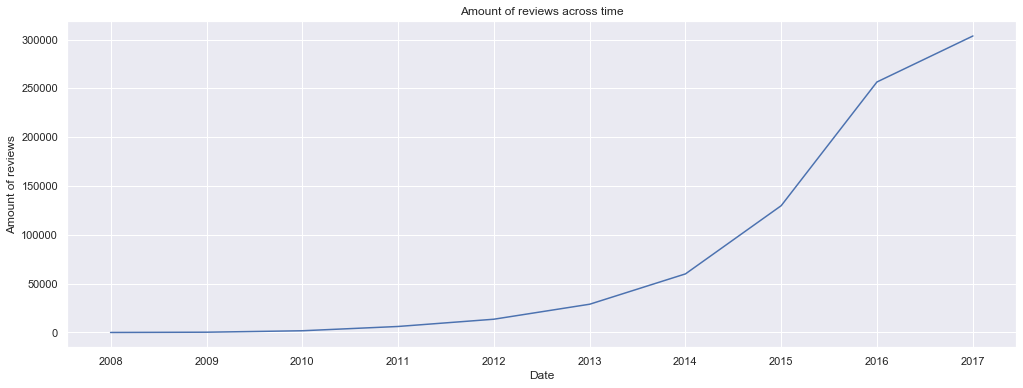

In [69]:
plt.figure(figsize=(17, 6))
plt.plot(rev_per_year["year"], rev_per_year["counts"])
plt.title("Amount of reviews across time")
plt.xlabel("Date")
plt.ylabel("Amount of reviews")
plt.show()

### 2.16 Is there a link between availability (days per year) with the price? Determine both graphically and statistically. 
#### Correlation

In [70]:
np.corrcoef(listings_detail["price"], listings_detail["availability_365"])[0, 1]

0.06181718759338245

#### Regression
${Price_i} = \alpha + \beta \thinspace Availability.365_{i}$

In [71]:
lr_model = LinearRegression()
lr_model.fit(X=listings_detail[["availability_365"]], y=listings_detail["price"])
price_est = lr_model.predict(listings_detail[["availability_365"]])

#### Graphically

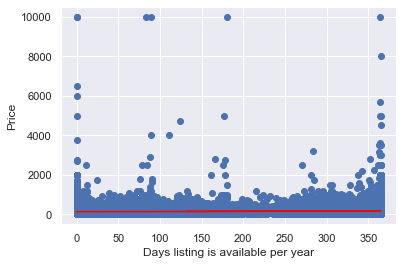

In [72]:
plt.scatter(listings_detail["availability_365"], listings_detail["price"])
plt.plot(listings_detail["availability_365"], price_est, "-", color="red", label="predicted y")
plt.xlabel("Days listing is available per year")
plt.ylabel("Price")
plt.show()

### 2.17 Is there a link between how many times the word ‘great’ appears in a review and the listing price? Determine both graphically and statistically. 

In [73]:
# count how many times 'great' is mentioned in a review
reviews_detail["times_great_in_comments"]= reviews_detail["comments"].str.lower().str.count("great")

# group every review with the same listing id together and add up how many times 'great' is mentioned
times_great = reviews_detail[["listing_id", "times_great_in_comments"]].groupby(by = "listing_id").sum()

# join with listings_summary to get price of the listing
times_great_listings = pd.merge(times_great, listings_summary[["id", "price"]], how="inner", left_on="listing_id", right_on = "id")

#### Correlation

In [74]:
# linear correlation
np.corrcoef(times_great_listings["price"], times_great_listings["times_great_in_comments"])[0,1]

0.02488704399026062

#### Regression
${Price_i} = \alpha + \beta \thinspace Times.Great_{i}$

In [75]:
lr_model = LinearRegression()
lr_model.fit(X=times_great_listings[["times_great_in_comments"]], y=times_great_listings["price"])
price_est = lr_model.predict(times_great_listings[["times_great_in_comments"]])

#### Graphically

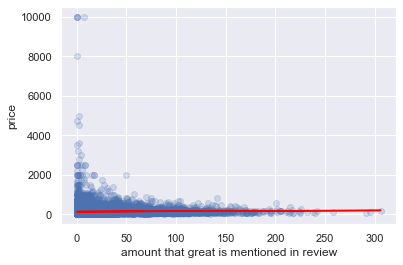

In [76]:
plt.scatter(x = times_great_listings["times_great_in_comments"], y = times_great_listings["price"], alpha = 0.2)
plt.plot(times_great_listings["times_great_in_comments"], price_est, "-", color="red", label="predicted y")

plt.xlabel("amount that great is mentioned in review")
plt.ylabel("price")
plt.show()

### 2.18 Plot how the number of Airbnb locations are distributed across the city on a map. Plot the number of locations per neighborhood and color code according to neighborhood group.

In [77]:
# calculating the listings per neighbourhood
listings_per_nb = listings_summary[["id", "neighbourhood", "neighbourhood_group"]].groupby(by = ["neighbourhood", "neighbourhood_group"]).size().reset_index(name="counts")
long_lat_per_nb = listings_summary[["neighbourhood", "longitude", "latitude"]].groupby(by = "neighbourhood").mean()

In [78]:
# geomap
m = folium.Map([40.6976637, -74.1197643], tiles='cartodbpositron', zoom_start=10)
# location=[float(long_lat_per_nb.iloc[i]['longitude']), float(long_lat_per_nb.iloc[i]['latitude'])],

for i in range(0,len(listings_per_nb)):
    nbg = listings_per_nb.iloc[i]['neighbourhood_group']
    col = ""
    if nbg == "Queens":
        col = "#F23D4C"
    elif nbg == "Bronx":
        col = "#735571"
    elif nbg == "Brooklyn":
        col = "#04BFBF"
    elif nbg == "Staten Island":
        col = "#C6D93B"
    else:
        col = "#F2B705"
        
    folium.Circle(
      location=[float(long_lat_per_nb.iloc[i]['latitude']), float(long_lat_per_nb.iloc[i]['longitude'])],
      popup=listings_per_nb.iloc[i]['neighbourhood'],
      radius=int(listings_per_nb.iloc[i]['counts']),
      color=col,
      fill=True,
      fill_color=col
    ).add_to(m)

# legend
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 130px; height: 160px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            background-color: rgba(242, 243, 245, 0.5)
                            ">
                              &nbsp; Queens &nbsp; <i class="fa fa-map-marker fa-2x" style="color:#F23D4C"></i><br>
                              &nbsp; Bronx &nbsp; <i class="fa fa-map-marker fa-2x" style="color:#735571"></i><br>
                              &nbsp; Brooklyn &nbsp; <i class="fa fa-map-marker fa-2x" style="color:#04BFBF"></i><br>
                              &nbsp; Staten Island &nbsp; <i class="fa fa-map-marker fa-2x" style="color:#C6D93B"></i><br>
                              &nbsp; Manhattan &nbsp; <i class="fa fa-map-marker fa-2x" style="color:#F2B705"></i>
                </div>
                ''' 

m.get_root().html.add_child(folium.Element(legend_html))

m.save("./assets/graphs/listings.html")

m

### 2.19 Williamsburg is a ‘hip’ area in in Brooklyn with a lot of Airbnb locations on offer. Explore how this area differs from other locations and visualize. You may also use external data sources.

In [79]:
listings_summary['entire_home'] = listings_summary.apply(lambda row: 1 if row["room_type"] == "Entire home/apt" else 0, axis = 1)
entire_home = listings_summary[["neighbourhood", "neighbourhood_group", "entire_home"]].groupby(["neighbourhood_group", "neighbourhood"]).sum().reset_index()

In [81]:
m = folium.Map([40.6976637, -74.1197643], tiles='cartodbpositron', zoom_start=10)

m.choropleth(
    geo_data= geo_json_data,
    name='choropleth',
    data= entire_home,
    columns=['neighbourhood', 'entire_home'],
    key_on='properties.neighbourhood',
    fill_color='Blues',
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name='Amount of entire homes/apartments'
)

# m.save("./assets/graphs/prices.html")

m

### 2.20  Create a stacked bar chart of the distribution of room type per neighborhood group. Statistically test whether these differences are significant.

In [82]:
# counts the number of room types for each neighbourhood group
df = listings_summary[["room_type", "neighbourhood_group"]].groupby(["neighbourhood_group", "room_type"]).size().reset_index(name="counts")

In [83]:
a = np.array(df.groupby("neighbourhood_group").sum().reset_index()["counts"])

In [84]:
for i in range(0, len(df)):
    if df["neighbourhood_group"].iloc[i] == "Bronx":
        df["counts"].iloc[i] = df["counts"].iloc[i] / a[0]
df

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


neighbourhood_group        room_type        counts
0                Bronx  Entire home/apt      0.279898
1                Bronx     Private room      0.671756
2                Bronx      Shared room      0.048346
3             Brooklyn  Entire home/apt   8264.000000
4             Brooklyn     Private room   9750.000000
5             Brooklyn      Shared room    355.000000
6            Manhattan  Entire home/apt  11735.000000
7            Manhattan     Private room   7935.000000
8            Manhattan      Shared room    565.000000
9               Queens  Entire home/apt   1600.000000
10              Queens     Private room   2601.000000
11              Queens      Shared room    171.000000
12       Staten Island  Entire home/apt    136.000000
13       Staten Island     Private room    158.000000

#### Stacked bar chart (absolute values)

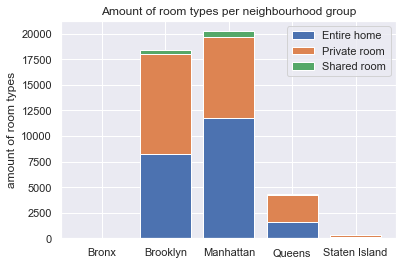

In [85]:
# stacked bar chart

# x
nbg = df["neighbourhood_group"].unique()

# y
bars1 = df[df["room_type"] == "Entire home/apt"]["counts"]
bars1
bars2 = df[df["room_type"] == "Private room"]["counts"]
bars3 = df[df["room_type"] == "Shared room"]["counts"]

# Staten Island has no shared rooms
# manually add 0 for shared rooms in staten island
# refactor later
bars3 = bars3.append(pd.Series([0]))

# bottoms
bottom2 = bars1
bottom3 = np.add(bars1, bars2).tolist()

# draw bars
plt.bar(nbg, bars1, label = "Entire home")
plt.bar(nbg, bars2, bottom = bottom2, label = "Private room")
plt.bar(nbg, bars3, bottom = bottom3, label = "Shared room")

# legend
plt.legend(loc="upper right")

plt.ylabel("amount of room types")
plt.title("Amount of room types per neighbourhood group")

plt.show()

#### Stacked bar chart (percentages)

[28, 45, 58, 37, 46]
[95, 98, 97, 96, 100]


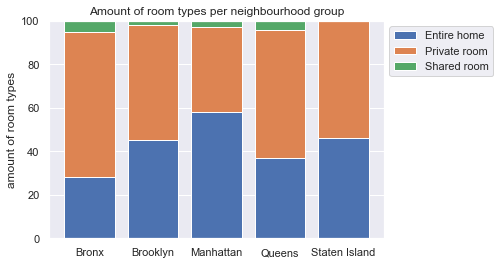

In [86]:
# Calculating percentages
distr_room_type = listings_summary[["neighbourhood_group", "room_type"]].groupby("neighbourhood_group")["room_type"].value_counts(normalize = True).rename("percentage").mul(100).reset_index()
distr_room_type["percentage"] = distr_room_type["percentage"].round()
distr_room_type["percentage"] = pd.to_numeric(distr_room_type["percentage"])

# stacked bar chart

# x
nbg = distr_room_type["neighbourhood_group"].unique()

# y
bars1 = distr_room_type[distr_room_type["room_type"] == "Entire home/apt"]["percentage"]
l1 = []
for i in range(len(bars1)):
    l1.append(int(bars1.iloc[i]))
    
bars2 = distr_room_type[distr_room_type["room_type"] == "Private room"]["percentage"]
l2 = []
for i in range(len(bars2)):
    l2.append(int(bars2.iloc[i]))
    
bars3 = distr_room_type[distr_room_type["room_type"] == "Shared room"]["percentage"]
# Staten Island has no shared rooms
# manually add 0 for shared rooms in staten island
# refactor later
bars3 = bars3.append(pd.Series([0]))
l3 = []
for i in range(len(bars3)):
    l3.append(int(bars3.iloc[i]))
    
# bottoms
bottom2 = l1
print(bottom2)
bottom3 = np.add(l1, l2).tolist()
print(bottom3)

# draw bars
plt.bar(nbg, l1, label = "Entire home")
plt.bar(nbg, l2, bottom = bottom2, label = "Private room")
plt.bar(nbg, l3, bottom = bottom3, label = "Shared room")

# legend
plt.legend(bbox_to_anchor=(1, 1))

plt.ylabel("amount of room types")
plt.title("Amount of room types per neighbourhood group")

plt.show()

#### Statistical tests

In [87]:
distr_room_type = listings_summary[["neighbourhood_group", "room_type"]].groupby("neighbourhood_group")["room_type"].value_counts(normalize = True).rename("percentage").mul(100).reset_index()

#insert 0% value for staten island
staten_island = pd.DataFrame({"neighbourhood_group":["Staten Island"], "room_type":["Shared room"], "percentage": [0]})
# staten_island
distr_room_type = distr_room_type.append(staten_island, ignore_index=True)

In [88]:
# ANOVA statsmodel only private room
distr_private = distr_room_type[distr_room_type["room_type"] == "Private room"]
# distr_private

results = smf.ols('percentage ~ C(neighbourhood_group)', data=distr_private).fit()
results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\stats\stattools.py:71: ValueWarning: omni_normtest is not valid with less than 8 observations; 5 samples were given.
  "samples were given." % int(n), ValueWarning)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1648: RuntimeWarning: divide by zero encountered in true_divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1649: RuntimeWarning: invalid value encountered in double_scalars
  * (1 - self.rsquared))
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1665: RuntimeWarning: divide by zero encountered in double_scalars
  return self.ssr/self.df_resid
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\regression\linear_model.py:1578: RuntimeWarning: divide by zero encountered in double_scalars
  return np.dot(wresid, wresid) / self.df_resid


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             percentage   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sat, 26 Oct 2019   Prob (F-statistic):                nan
Time:                        17:06:53   Log-Likelihood:                 147.81
No. Observations:                   5   AIC:                            -285.6
Df Residuals:                       0   BIC:                            -287.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  67.1756        inf          0        nan         nan         nan
C(neighbourhood_group)[T.Brooklyn]        -14.0970        inf         -0        nan         nan         nan
C(neighbourhood_group)[T.Manhattan]       -27.9613        inf         -0        nan         nan         nan
C(neighbourhood_group)[T.Queens]           -7.6833        inf         -0        nan         nan         nan
C(neighbourhood_group)[T.Staten Island]   -13.4341        inf         -0        nan         nan         nan
==============================================================================
Omnibus:                          nan   Durbin-Watson:                   0.820
Prob(Omnibus):                    nan   Jarque-Bera (JB):                1.124
Skew:                           1.152   Prob(JB):                        0.570
Kurtosis:                       2.714   Cond. No.                         5.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [89]:
# ANOVA statsmodel including all room_types
distr_room_type

results = smf.ols('percentage ~ C(neighbourhood_group)', data=distr_room_type).fit()
results.summary()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=15
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             percentage   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.400
Method:                 Least Squares   F-statistic:                     0.000
Date:                Sat, 26 Oct 2019   Prob (F-statistic):               1.00
Time:                        17:06:56   Log-Likelihood:                -68.679
No. Observations:                  15   AIC:                             147.4
Df Residuals:                      10   BIC:                             150.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  33.3333     16.662      2.001      0.073      -3.792      70.458
C(neighbourhood_group)[T.Brooklyn]       3.553e-15     23.563   1.51e-16      1.000     -52.502      52.502
C(neighbourhood_group)[T.Manhattan]              0     23.563          0      1.000     -52.502      52.502
C(neighbourhood_group)[T.Queens]         3.553e-15     23.563   1.51e-16      1.000     -52.502      52.502
C(neighbourhood_group)[T.Staten Island] -3.553e-15     23.563  -1.51e-16      1.000     -52.502      52.502
==============================================================================
Omnibus:                        5.193   Durbin-Watson:                   2.477
Prob(Omnibus):                  0.075   Jarque-Bera (JB):                1.562
Skew:                          -0.272   Prob(JB):                        0.458
Kurtosis:                       1.516   Cond. No.                         5.83
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [90]:
# ANOVA scipy inlcuding all room_types
bronx = distr_room_type[distr_room_type["neighbourhood_group"] == "Bronx"]["percentage"]
brooklyn = distr_room_type[distr_room_type["neighbourhood_group"] == "Brooklyn"]["percentage"]
manhattan = distr_room_type[distr_room_type["neighbourhood_group"] == "Manhattan"]["percentage"]
queens = distr_room_type[distr_room_type["neighbourhood_group"] == "Queens"]["percentage"]
staten_island = distr_room_type[distr_room_type["neighbourhood_group"] == "Staten Island"]["percentage"]

stats.f_oneway(bronx, brooklyn, manhattan, queens, staten_island)

F_onewayResult(statistic=7.324885499895732e-33, pvalue=1.0)

### 2.21 Color-coded plot the most popular room type per neighborhood on a city map.

In [91]:
# compute most popular room_type per neighbourhood
distr_room_type = listings_summary[["neighbourhood", "room_type"]].groupby("neighbourhood")["room_type"].value_counts(normalize = True).rename("percentage").mul(100).reset_index()

agg_dict = {"percentage":np.max}
temp = distr_room_type.groupby("neighbourhood").agg(agg_dict)

popular_room_type = distr_room_type.merge(temp, how = "right", on = ["neighbourhood","percentage"])

In [92]:
# shared room: red, private room: yellow, entire home: green
def my_color_function(feature):
    if feature['properties']['neighbourhood'] not in listings_summary["neighbourhood"].unique():
        return "#d3d3d3"
    room = popular_room_type[popular_room_type["neighbourhood"] == feature['properties']['neighbourhood']]["room_type"]
    a = room.to_string().split()
    room = " ".join(a[1:])
    if room == "Shared room":
        return '#ff0000'
    elif room == "Private room":
        return '#ffff00'
    else:
        return '#008000'

In [93]:
m = folium.Map([40.6976637, -74.1197643], tiles='cartodbpositron', zoom_start=10)

folium.GeoJson(
    geo_json_data,
    style_function=lambda feature: {
        'fillColor': my_color_function(feature),
        'color': 'black',
        'weight': 1,
        'dashArray': '5, 5',
    }
).add_to(m)

# legend
legend_html =   '''
                <div style="position: fixed; 
                            bottom: 50px; left: 50px; width: 200px; height: 100px; 
                            border:2px solid grey; z-index:9999; font-size:14px;
                            background-color: rgba(242, 243, 245, 0.5)
                            ">
                              &nbsp; Entire home/apartment &nbsp; <i class="fa fa-map-marker fa-2x" style="color:green"></i><br>
                              &nbsp; Private room &nbsp; <i class="fa fa-map-marker fa-2x" style="color:yellow"></i><br>
                              &nbsp; Shared room &nbsp; <i class="fa fa-map-marker fa-2x" style="color:red"></i>
                </div>
                ''' 

m.get_root().html.add_child(folium.Element(legend_html))

# m.save("./assets/graphs/room_type.html")

m

### 2.22 Comparing price for every weekday

In [94]:
calendar_detail["weekday"] = calendar_detail["date"].apply(lambda x: x.weekday())

In [95]:
calendar_detail[["price", "weekday"]].groupby("weekday").mean()

price
weekday            
0        168.684574
1        168.373545
2        168.195359
3        168.297459
4        174.693332
5        174.902118
6        169.176612

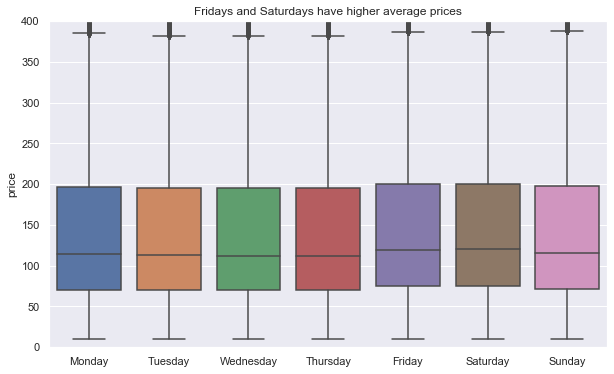

In [96]:
sns.set_style("darkgrid")
plt.figure(figsize=(10,6))
g = sns.boxplot(x = calendar_detail["weekday"], y = calendar_detail["price"])
g.set(title = "Fridays and Saturdays have higher average prices")
g.set(ylim=(0,400))
g.set(xticklabels=["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"])
g.set(xlabel = "")

# plt.savefig("./assets/Price_weekdays.png" , dpi = 300)
g


### 2.23 Estimating occupancy rate
In an interview in 2014 with the CEO of AirBnB, he said that only 72% of guests leave reviews. We can use this to estimate the demand per month of an airbnb by divinding the reviews per month by 0.72.

In [97]:
# demand per month
listings_summary["demand_per_month"] = listings_summary["reviews_per_month"] / 0.72

# demand per year
listings_summary["demand_per_year"] = listings_summary["demand_per_month"] * 12

We can calculate the minimum amount of days a listing was rented in a year by multiplying the demand with the minimum nights you have to stay in that listing.

In [98]:
listings_summary["min_days_rented"] = listings_summary["demand_per_year"] * listings_summary["minimum_nights"]

Three sources from 2012 and 2014 state approximately 5.1 nights as the average length of stay. We can use this to estimate the average days a listing was rented.

In [99]:
listings_summary["avg_days_rented"] = listings_summary["demand_per_year"] * 5.1

We can now determine the occupancy rate by dividing these two measures by the number of day in a year.

In [100]:
listings_summary["min_occupancy"] = listings_summary["min_days_rented"] / 365
listings_summary["avg_occupancy"] = listings_summary["avg_days_rented"] / 365

In [101]:
def add_quantile(l, column, quantile):
    l.append(np.quantile(column, quantile))

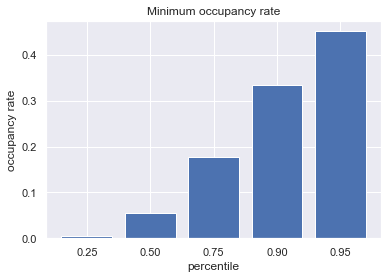

In [102]:
l = []
quantiles = [0.25,0.50,0.75,0.90,0.95]
labels = ["0.25","0.50","0.75","0.90","0.95"]

for quantile in quantiles:
    add_quantile(l, listings_summary["min_occupancy"], quantile)
    
plt.bar(labels,l)
plt.xlabel("percentile")
plt.ylabel("occupancy rate")
plt.title("Minimum occupancy rate")
plt.show()

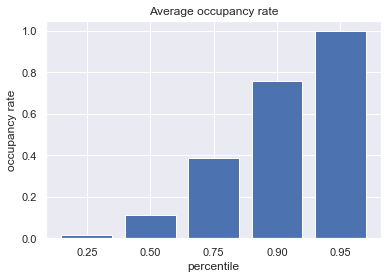

In [103]:
l = []
quantiles = [0.25,0.50,0.75,0.90,0.95]
labels = ["0.25","0.50","0.75","0.90","0.95"]

for quantile in quantiles:
    add_quantile(l, listings_summary["avg_occupancy"], quantile)
    
plt.bar(labels,l)
plt.xlabel("percentile")
plt.ylabel("occupancy rate")
plt.title("Average occupancy rate")
plt.show()

### 2.24 Estimating revenue
Now we have an estimate for the demand of every listing, we can estimate the revenue each listing makes by multiplying the estimated minimum/average days the listing was rented with the listing price.

In [104]:
listings_summary["est_min_rev"] = listings_summary["min_days_rented"] * listings_summary["price"]
listings_summary["est_avg_rev"] = listings_summary["avg_days_rented"] * listings_summary["price"]

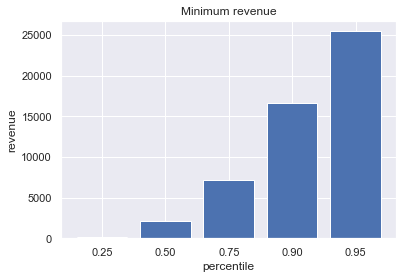

In [105]:
l = []
quantiles = [0.25,0.50,0.75,0.90,0.95]
labels = ["0.25","0.50","0.75","0.90","0.95"]

for quantile in quantiles:
    add_quantile(l, listings_summary["est_min_rev"], quantile)
    
plt.bar(labels,l)
plt.xlabel("percentile")
plt.ylabel("revenue")
plt.title("Minimum revenue")
plt.show()

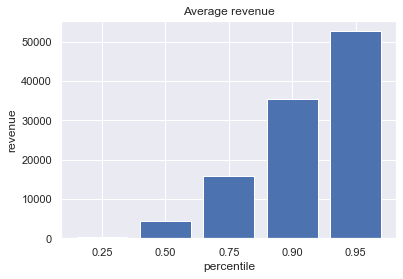

In [106]:
l = []
quantiles = [0.25,0.50,0.75,0.90,0.95]
labels = ["0.25","0.50","0.75","0.90","0.95"]

for quantile in quantiles:
    add_quantile(l, listings_summary["est_avg_rev"], quantile)
    
plt.bar(labels,l)
plt.xlabel("percentile")
plt.ylabel("revenue")
plt.title("Average revenue")
plt.show()